**Authors:**
Jonas Juhler-Nøttrup (S164217), Niels Asp Fuglsang (S164181), Morten Wehlast Jørgensen (S147056), Jens Thuren Lindahl (S124347)

## 42186 Model-based Machine Learning - Bayesian Spatial Count

Research topic: How may we model non-linear dependencies on the inputs $\textbf{X}_n$?

More specifically, we wish to determine the advantages and disadvantages of the following approaches:
- Neural network 
- Hierarchical modelling

For each area $n$ in data set, we observe a count of injuries, $y_n$. 
The normal apprach is to assume linear dependence such that
$$
y_n \sim \text{NB}(r, p_n) \\
p_n= \frac{\exp(\psi_n)}{1+\exp(\psi_n)} \\
\psi_n = \beta^T\textbf{X}_n+\phi_n
$$

Where $\textbf{X}_n$ are the characteristics of the area and $\phi_n$ is a correlated error term with mean 0 and standard deviation $\sigma$.

### Neural Network

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now split the characteristics into a set of inputs for our linear term, $\textbf{X}'_n$ and a set of inputs for our non-linear term, $\textbf{X}^*_n$, such that
$$
\psi_n = \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

#### PGM
![image info](./neural_net_pgm.jpg)


#### Generative Process

<ol>
    <li> Set hyperparameter $r$. </li>
    <li> Set hyperparameter $\sigma$. </li>
    <li> Draw linear coefficients $\beta \sim N(\beta|\textbf{0},\lambda \textbf{I})$</li>
    <li> Draw non-linear coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

### Hierarchical model
By inspection of the data, we see that groupings can be made based on feature [INSERT FEATURE]. Therefore, we now introduce a set of features [INSERT NOTATION] where feature [INSERT NOTATION] denotes the [INSERT FEATURE] of region $n$. Similarly, we introduce a shared global prior, that prevents overfitting by reducing the flexibility of the model.

Grouping could be based on the census tracts in the data. See this explanation of census tracts: https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf

## Data
https://figshare.com/articles/dataset/Data_for_Bayesian_Hierarchical_Spatial_Models_nmplementing_the_Besag_York_Molli_Model_nn_Stan/9729149/1

In [54]:
# Load packages
!pip install pyro-ppl

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

from itertools import combinations

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

%matplotlib inline

## Data description
The data set consists of 7 features
 - `census_tract` ID for the census/region. Nominal, integer.
 - `ped_nnjury_5to18` Number of injuries for pedestrians aged 5-18 in the years 2005-2014. Ratio, integer.
 - `youth_pop_5to18` Population of youths aged aged 5-18 within the census/region in 2010. Ratio, integer.
 - `commute_priv_vehicle` Percentage commuters who traveled to work primarily by a private vehicle, from the American Community Survey for the years 2010-2014. Ration, continuous.
 - `med_hhincome` Median household income from American Community Survey for the years 2010-2014. Interval, integer.
 - `avg_ann_daily_traffic` Maximum value of street-level annual average daily traffic values for that census tract from 2015. Interval, integer.
 - `fragment_nndex` A combined metric consisting of standardized data describing; estimates of vacant housing units, householders living alone, non-owner occupied housing units and population having moved within the previous year. Interval, continuous.
 
 
The project will treat `ped_nnjury_5to18` as the dependent variable $y$. 

First, we will look at some descriptive statistics for all non-nominal features.<br>
Next, we visualize them to get a better understanding of their distributions.

## Descriptive Statistics

In [55]:
nominals = ["census_tract"]
df = pd.read_csv("./bym_nyc_study.csv")
df_nn = df[df.columns[~df.columns.isin(nominals)]] # Select all non-nominals for description
df_nn.describe() # Select all non-nominals for description

,ped_injury_5to18,youth_pop_5to18,commute_priv_vehicle,med_hhincome,avg_ann_daily_traffic,fragment_index
count,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2.095000e+03
mean,8.206683,596.447255,0.302574,58496.796181,37247.564932,-3.818575e-12
std,7.454526,370.046583,0.191031,28567.156059,43316.943386,2.677234e+00
min,0.000000,6.000000,0.000000,9327.000000,843.000000,-6.728742e+00
25%,3.000000,326.000000,0.145954,38624.000000,12341.000000,-1.818569e+00
50%,6.000000,510.000000,0.260870,53882.000000,19178.000000,-1.085420e-01
75%,11.500000,789.500000,0.439009,72928.500000,37201.000000,1.436548e+00
max,57.000000,3315.000000,0.902256,232266.000000,276476.000000,1.867200e+01


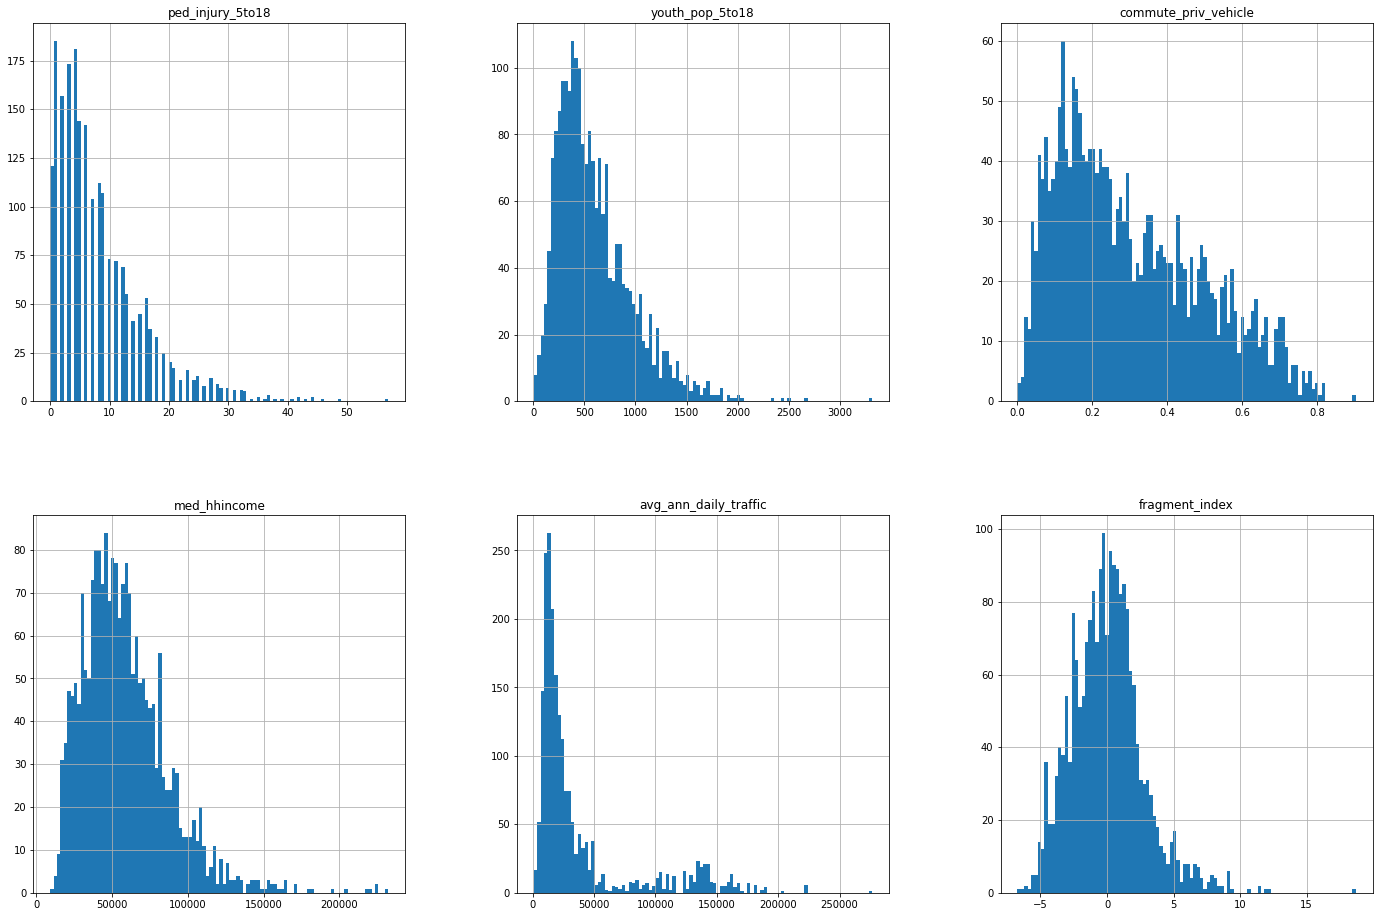

In [56]:
fig, axes = plt.subplots(len(df_nn.columns)//3, 3, figsize=(24, 16))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_nn.hist(column = df_nn.columns[i], bins = 100, ax=axis)
        i = i+1

In [57]:
df_census = pd.read_csv("./nyc_census_tracts.csv")
merged_df = df.merge(df_census, how="left", left_on="census_tract", right_on="CensusTract")

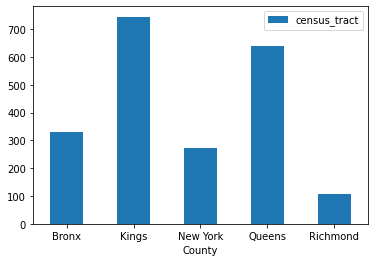

In [59]:
fig, ax = plt.subplots(1,1)
merged_df.groupby("County").count().plot.bar(y="census_tract", ax=ax, rot=0)
plt.show()